In [73]:
import torch
import numpy as np
from cryodrgn.source import ImageSource
import os
import pickle
import torch

emds = list(set([x[:-5] for x in os.listdir("/nobackup/users/jamesron/projections/") if x.startswith("emd") and x.endswith("mrcs")]))
emds = emds[:100]

In [74]:
imglist = []
poselist = []
ids = []

for i,e in enumerate(emds):
    imglist.append(ImageSource.from_file("/nobackup/users/jamesron/projections/" + e + ".mrcs").images())
    poselist.append(pickle.load(open("/nobackup/users/jamesron/projections/" + e + "_pose.pkl", 'rb')))
    ids.append(int(e.split("_")[-1]))
    if i % 100 == 0:
        print(i)

0


In [75]:
ids = torch.tensor(ids, dtype=torch.long).unsqueeze(-1).expand([-1, imglist[0].shape[0]]).reshape(-1)
imglist = torch.stack(imglist, dim=0).view((-1, *imglist[0].shape[1:]))
phis = torch.tensor([x[0] for x in poselist]).view(-1)
thetas = torch.tensor([x[1] for x in poselist]).view(-1)


In [76]:
print(imglist.shape)
print(phis.shape)
print(thetas.shape)
print(ids.shape)

torch.Size([19200, 128, 128])
torch.Size([19200])
torch.Size([19200])
torch.Size([19200])


In [81]:
import sys

sys.path.insert(1, "/nobackup/users/jamesron/broeyjoey/")
from data import ContrastiveProjectionDataset

dataset = ContrastiveProjectionDataset(imglist, phis, thetas, ids, dfu=[10000, 15000, 20000, 25000], snr1=[7.5,9,12, 15], pos_angle_threshold=30)
loader = torch.utils.data.DataLoader(dataset, collate_fn=lambda x: ContrastiveProjectionDataset.collate_fn(x, dataset.lat, dataset.mask, dataset.freqs), shuffle=True, batch_size=8)

(INFO) (lattice.py) (26-Feb-25 22:59:22) Using circular lattice with radius=64


In [82]:
images, ctf, posdist = next(iter(loader))

(<Figure size 450x150 with 3 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object))

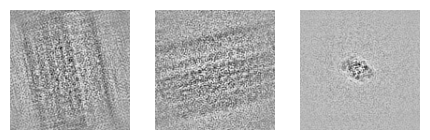

In [90]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot_projections(imgs, labels=None, max_imgs=25):
    if len(imgs) > max_imgs:
        imgs = imgs[:max_imgs]

    N = len(imgs)
    nrows = 1
    ncols = N

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows)
    )

    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    if labels is None:
        labels = [None for _ in axes.ravel()]

    for img, ax, lbl in zip(imgs, axes.ravel(), labels):
        ax.imshow(img, cmap="Greys_r")
        if lbl is not None:
            ax.set_title(lbl)
        ax.axis("off")

    plt.tight_layout()
    return fig, axes

plot_projections(images[7])

In [124]:
images.shape

torch.Size([8, 3, 128, 128])

In [105]:
images[1]

tensor([[[-0.0164,  0.0439,  0.0302,  ...,  0.0134, -0.0109,  0.0316],
         [ 0.0424,  0.1337,  0.1479,  ..., -0.0164,  0.0220,  0.0161],
         [-0.0624, -0.0258,  0.0587,  ..., -0.0237,  0.0364,  0.0212],
         ...,
         [ 0.0172, -0.0257, -0.0450,  ...,  0.1650,  0.0402,  0.0371],
         [-0.0325,  0.0404,  0.0743,  ...,  0.0446, -0.0688,  0.1157],
         [-0.2139, -0.0029,  0.0727,  ...,  0.0559,  0.0146,  0.0594]],

        [[-0.5767, -0.3719, -0.2770,  ..., -0.1392, -0.0360, -0.4391],
         [ 0.2365,  0.1243, -0.2657,  ..., -0.1192,  0.5811,  0.1791],
         [-0.0255, -0.6944, -0.2124,  ..., -0.1710,  0.2057,  0.0887],
         ...,
         [ 0.4884, -0.3480,  0.1245,  ..., -0.1401, -0.3605, -0.0111],
         [-0.1718, -0.8897, -0.1319,  ..., -0.1310, -0.3318,  0.0171],
         [ 0.2046, -0.2157, -0.1858,  ..., -0.1325, -0.5634,  0.2518]],

        [[-0.0653,  0.0413, -0.0880,  ...,  0.1659, -0.0078,  0.0029],
         [ 0.0211,  0.1242,  0.0323,  ..., -0

In [93]:
ctf[0]

tensor([[9.0000e+00, 3.0000e+00, 1.0000e+04, 1.0500e+04, 0.0000e+00, 3.0000e+02,
         2.7000e+00, 1.0000e-01, 0.0000e+00],
        [1.2000e+01, 4.0000e+00, 2.0000e+04, 2.0500e+04, 0.0000e+00, 3.0000e+02,
         2.7000e+00, 1.0000e-01, 0.0000e+00],
        [9.0000e+00, 3.0000e+00, 2.5000e+04, 2.5500e+04, 0.0000e+00, 3.0000e+02,
         2.7000e+00, 1.0000e-01, 0.0000e+00]])

In [108]:
ctf[2]

tensor([[1.2000e+01, 4.0000e+00, 2.0000e+04, 2.0500e+04, 0.0000e+00, 3.0000e+02,
         2.7000e+00, 1.0000e-01, 0.0000e+00],
        [6.0000e+00, 2.0000e+00, 1.0000e+04, 1.0500e+04, 0.0000e+00, 3.0000e+02,
         2.7000e+00, 1.0000e-01, 0.0000e+00],
        [1.2000e+01, 4.0000e+00, 2.0000e+04, 2.0500e+04, 0.0000e+00, 3.0000e+02,
         2.7000e+00, 1.0000e-01, 0.0000e+00]])